Practical Work: Out-of-Distribution Detection, OOD Scoring Methods, and Neural Collapse.

# 1. Training a ResNet18 classifier on CIFAR-100 with PyTorch

In [53]:
import torch
import torchvision
from torchvision.models import resnet18
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [54]:
# Hyperparameters (Improved to reduce overfitting)
batch_size = 128 
num_workers = 12  # since 
lr = 1e-1 
momentum = 0.9  
weight_decay = 1e-3  
epochs = 200  # Increased from 100
dropout = 0.55 
# Skip training and load model locally.
# If never trained, set to False to train and save the model first.
skip_training = True # True to skip

# Random seed
torch.manual_seed(42)


In [55]:

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    transforms.RandomErasing(p=0.25),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])


# Load CIFAR-100
train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Model configuration
model = resnet18(True)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=dropout),
    torch.nn.Linear(model.fc.in_features, 100)
)
model = model.cuda()

# Optim, Loss, Scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Training loop
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    print(f"Epoch {epoch}: Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc

# Simple Test Loop
def test(epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    print(f"Test Accuracy: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc

Using device: cuda


/users/eleves-a/2024/boyuan.zhang/Aster-WorkSpace/CV/OOD_venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
/users/eleves-a/2024/boyuan.zhang/Aster-WorkSpace/CV/OOD_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/users/eleves-a/2024/boyuan.zhang/Aster-WorkSpace/CV/OOD_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You 

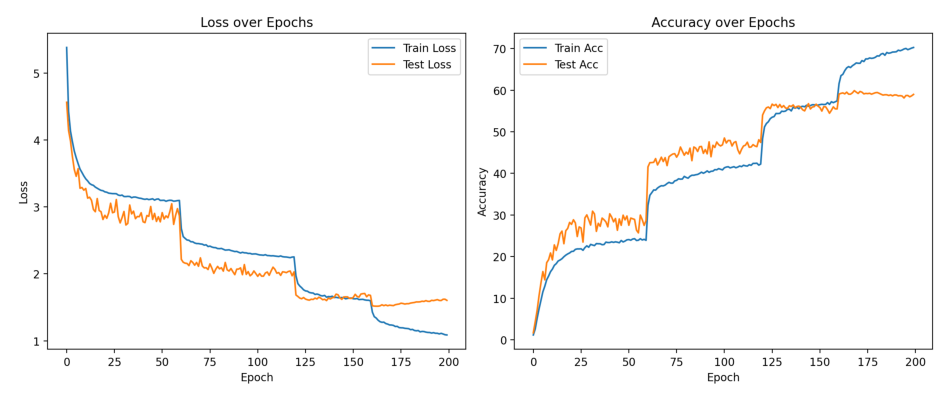

In [56]:
# Load model
if skip_training:  # Change to True to load the model
    try:
        model.load_state_dict(torch.load('resnet18_cifar100.pth', map_location=device))
        plot_path = "training_curves.png"
        img = plt.imread(plot_path)
        plt.figure(figsize=(12, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    except FileNotFoundError:
        assert False, "Model or training curves not found. Please train the model first."
else:
    # Main training and testing loop
    for epoch in range(epochs):
        train_loss, train_acc = train(epoch)
        test_loss, test_acc = test(epoch)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        scheduler.step()

    # Save model
    torch.save(model.state_dict(), 'resnet18_cifar100.pth')

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_curves.png", dpi=200, bbox_inches="tight")
    plt.show()





# 2. Implement and compare OOD scores
Implement and compare the following OOD scores:

· Max Softmax Probability (MSP)

· Maximum Logit Score

· Mahalanobis

· Energy Score

· ViM

## 2.1 Max Softmax Probability (MSP). 
If the classifier assigns low maximum probability, it is unsure or the input may be OOD.

Score: the maximum softmax probability
$$s_{max-prob}(x)=\mathop{max}\limits_{c} p(y=c|x)=\mathop{max}\limits_{c} softmax(z_c(x))$$

In [57]:
def msp_score(model, loader):
    model.eval()
    all_scores = []

    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            probs = F.softmax(logits, dim=1)

            max_probs, _ = torch.max(probs, dim=1)
            
            all_scores.append(max_probs.cpu())
            
    return torch.cat(all_scores)

msp_scores = msp_score(model, test_loader)

print(f"MSP scores: {msp_scores}")

MSP scores: tensor([0.4402, 0.5902, 0.3835,  ..., 0.9999, 0.6615, 0.6565])


## 3. Max Logit technique. 
Logits reflect raw model evidence before the softmax normalization; using logits avoids saturating effects of softmax.
$$s_{max-logit}(x)= \mathop{max}\limits_{c}\ z_c(x)$$

In [58]:
def max_logit_score(model, loader):
    model.eval()
    all_scores = []
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            max_logits, _ = torch.max(logits, dim=1)
            all_scores.append(max_logits.cpu())
    return torch.cat(all_scores)

max_logit_scores = max_logit_score(model, test_loader)
print(f"Max logit scores: {max_logit_scores}")

Max logit scores: tensor([ 5.8458,  8.7173,  6.6667,  ..., 14.9702,  6.9979,  9.1141])


## 4. Energy-based OOD score.

Energy provides a scalar that correlates with the model’s
total evidence across classes. Lower energy (more negative) implies
stronger evidence; higher energy (less negative or positive) can
indicate OOD. Energy score derived from the logits: a common definition:

$$  E(x) = -log(\sum_{c}{ }e^{z_c(x)}) = -LSE(z(x))$$

With temperature $T>0$ one can use:
$$ E_T(x) = -T*log(\sum_{c}{ }e^{z_c(x)/T})$$

In [59]:
def energy_score(model, loader, Temperature=1):
    model.eval()
    all_scores = []
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            # Though in the formula, E is negative, it is kept positive here for easier comparison.
            # Note that Temperature is greater than 0.
            if Temperature <= 0:
                raise ValueError("Temperature must be greater than 0.")
            energy = Temperature * torch.logsumexp(logits / Temperature, dim=1)
            all_scores.append(energy.cpu())
    return torch.cat(all_scores)

energy_scores = energy_score(model, test_loader, Temperature=1)
print(f"Energy scores: {energy_scores}")

Energy scores: tensor([ 6.6663,  9.2445,  7.6251,  ..., 14.9703,  7.4112,  9.5350])


## 5. Mahalanobis Distance-based OOD Detection

For each class $c$, compute the class mean in feature space:
$$ \mu _c = 1/N_c \sum_{i:y_i=c}{}{f(x_i)} $$

Then, estimate a shared covariance matrix $\Sigma$ (or per-class covariance), typically eh empirical covariance of features across the training set.

Therefore, the Mahalanobis score calculated as:
$$ d_{ M a h a } ( x ) = \operatorname* { m i n } _ { c } \, ( f ( x ) - \mu _ { c } ) ^ { \top } \Sigma ^ { - 1 } ( f ( x ) - \mu _ { c } ) $$

For each test sample, calculate the distance to all 100 class centers and take the minimum distance as the OOD score (the smaller the distance, the more similar to an in-distribution sample).

In [60]:
features_buffer = []

def hook_fn(module, input, output):
    # output shape is [batch, 512, 1, 1], flatten it to [batch, 512]
    features_buffer.append(output.view(output.size(0), -1))

# General hook registration to the top avgpool layer (works for ResNet18/34/50/101)
handle = model.avgpool.register_forward_hook(hook_fn)

def extract_features(model, inputs):
    features_buffer.clear() 
    _ = model(inputs)       
    return features_buffer[0] 

def mahalanobis_score(model, train_loader, test_loader, num_classes=100):
    """
    Correct implementation of Mahalanobis distance:
    1. Compute the mean μ_c for each class (100 classes)
    2. Compute the covariance matrix Σ
    3. For each test sample, compute the distance to all classes and take the minimum
    """
    model.eval()
    
    # Step 1: Collect training features and labels
    print("Collecting training features...")
    train_features = []
    train_labels = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            features = extract_features(model, inputs)
            train_features.append(features.cpu())
            train_labels.append(labels)
    
    train_features = torch.cat(train_features)
    train_labels = torch.cat(train_labels)
    
    # Step 2: Compute the mean for each class
    print("Computing class means...")
    class_means = []
    for c in range(num_classes):
        class_features = train_features[train_labels == c]
        class_mean = torch.mean(class_features, dim=0)
        class_means.append(class_mean)
    class_means = torch.stack(class_means)  # shape: [100, feature_dim]
    
    # Step 3: Compute the covariance matrix (using global covariance)
    print("Computing covariance matrix...")
    cov = torch.cov(train_features.T) + 0.01 * torch.eye(train_features.size(1))
    inv_cov = torch.inverse(cov)
    
    # Step 4: Compute the minimum Mahalanobis distance to each class for the test set
    print("Computing Mahalanobis distances for the test set...")
    all_scores = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            features = extract_features(model, inputs).cpu()
            
            # For each sample in the batch
            batch_scores = []
            for feat in features:
                # Compute Mahalanobis distance to each class
                dists = []
                for class_mean in class_means:
                    diff = feat - class_mean
                    # Mahalanobis distance: sqrt(diff^T * Σ^-1 * diff). But according to the formula given in the slides,
                    # we use the squared distance.
                    dist = diff @ inv_cov @ diff
                    dists.append(dist.item())
                
                # Take the minimum distance (smaller distance means more likely to be an ID sample)
                min_dist = min(dists)
                batch_scores.append(-min_dist)  # Negative sign: higher score means more likely to be ID
            
            all_scores.append(torch.tensor(batch_scores))

    return torch.cat(all_scores)

mahalanobis_scores = mahalanobis_score(model, train_loader, test_loader)
print(f"Mahalanobis scores (first 10): {mahalanobis_scores[:10]}")

# Cleanup hook
if 'handle' in globals():
    handle.remove()
    features_buffer.clear()

Computing class means...
Computing covariance matrix...
Computing Mahalanobis distances for the test set...
Mahalanobis scores (first 10): tensor([-294.4252, -320.8476, -419.3646, -279.2027, -411.0163, -228.7846,
        -249.9227, -244.7492, -193.8926, -324.1290])


## 6. ViM (Virtual Matching) Score

ViM detects OOD samples by analyzing the principal component directions in the feature space:
- ID samples' features primarily reside in a low-dimensional subspace (formed by principal components)
- OOD samples exhibit larger projections beyond the principal component directions

$$s_{ViM}(x) = -\alpha \cdot \|P_{principal}(f(x) - \mu)\|_2 + \|P_{residual}(f(x) - \mu)\|_2$$

where:
- $P_{principal}$: projection onto the principal component subspace
- $P_{residual}$: projection onto the residual subspace (orthogonal complement space)
- $\alpha$: weighting parameter

In [61]:
features_buffer = []

def hook_fn(module, input, output):
    # output shape is [batch, 512, 1, 1], flatten it to [batch, 512]
    features_buffer.append(output.view(output.size(0), -1))

# General hook registration to the top avgpool layer (works for ResNet18/34/50/101)
handle = model.avgpool.register_forward_hook(hook_fn)

def extract_features(model, inputs):
    features_buffer.clear() 
    _ = model(inputs)       
    return features_buffer[0] 


def vim_score(model, train_loader, test_loader, num_principal_components=100, alpha=1.0):
    """
    ViM OOD detection method.
    
    Parameters:
    - num_principal_components: Number of principal components to retain
    - alpha: Weight for the principal component direction
    """
    model.eval()
    
    # Step 1: Collect training features
    print("Collecting training features for PCA...")
    train_features = []
    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            features = extract_features(model, inputs)
            train_features.append(features.cpu())
    
    train_features = torch.cat(train_features)
    
    # Step 2: Compute mean and center features
    print("Computing feature mean...")
    mean = torch.mean(train_features, dim=0)
    centered_features = train_features - mean
    
    # Step 3: PCA - Compute eigenvalues and eigenvectors of covariance matrix
    print("Performing PCA...")
    cov = torch.cov(centered_features.T)
    eigenvalues, eigenvectors = torch.linalg.eigh(cov)
    
    # Sort by eigenvalue in descending order
    idx = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Step 4: Select principal components and residual subspace
    principal_components = eigenvectors[:, :num_principal_components]  # Principal component directions
    residual_components = eigenvectors[:, num_principal_components:]   # Residual directions
    
    print(f"Retaining top {num_principal_components} principal components")
    print(f"Explained variance ratio of principal components: {eigenvalues[:num_principal_components].sum() / eigenvalues.sum():.4f}")
    
    # Step 5: Compute ViM scores for the test set
    print("Computing ViM scores for the test set...")
    all_scores = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            features = extract_features(model, inputs).cpu()
            
            # Center the features
            centered = features - mean
            
            # Project onto principal component subspace
            principal_proj = centered @ principal_components
            principal_norm = torch.norm(principal_proj, dim=1)
            
            # Project onto residual subspace
            residual_proj = centered @ residual_components
            residual_norm = torch.norm(residual_proj, dim=1)
            
            # ViM score: -alpha * ||principal component projection|| + ||residual projection||
            # OOD samples have larger components in the residual direction
            vim_scores = -alpha * principal_norm + residual_norm
            
            all_scores.append(vim_scores)
    
    return torch.cat(all_scores)

# Compute ViM scores
vim_scores = vim_score(model, train_loader, test_loader, num_principal_components=100, alpha=1.0)
print(f"ViM scores (first 10): {vim_scores[:10]}")

# Cleanup hook
if 'handle' in globals():
    handle.remove()
    features_buffer.clear()

Computing feature mean...
Performing PCA...
Retaining top 100 principal components
Explained variance ratio of principal components: 0.9185
Computing ViM scores for the test set...
ViM scores (first 10): tensor([-5.4166, -6.8709, -5.2100, -5.2391, -9.4143, -6.1147, -5.4408, -5.9386,
        -7.7036, -8.8447])


# 3. Study the Neural Collapse phenomenon at the end of training NC1 to NC4. 

## NC1: variability collapse: at the end of training, the in-class variation collapses to very low, due to the feature of each class converges to the mean of the class.

In [62]:
import numpy as np
from sklearn.manifold import TSNE

#Extract penultimate layer features
def extract_features(model, data_loader, device='cuda'):
    model.eval()
    features_list = []
    labels_list = []
    
    def hook_fn(module, input, output):
        features_list.append(output.view(output.size(0), -1).detach().cpu())
    
    hook_handle = model.avgpool.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            _ = model(images)
            labels_list.append(targets.cpu())
    
    hook_handle.remove()
    
    features = torch.cat(features_list, dim=0).numpy()
    labels = torch.cat(labels_list, dim=0).numpy()
    
    return features, labels

#Extract training features
print("Extracting training features...")
train_features, train_labels = extract_features(model, train_loader, device='cuda')
print(f"Features shape: {train_features.shape}")
print(f"Labels shape: {train_labels.shape}")

#Compute class means and within-class variances
num_classes = 100
class_means = np.zeros((num_classes, train_features.shape[1]))
class_variances = []

for class_id in range(num_classes):
    class_mask = (train_labels == class_id)
    class_features = train_features[class_mask]
    
    class_mean = np.mean(class_features, axis=0)
    class_means[class_id] = class_mean
    
    variance = np.mean(np.var(class_features, axis=0))
    class_variances.append(variance)

print(f"Class means shape: {class_means.shape}")
print(f"Variances computed for {len(class_variances)} classes")


Extracting training features...
Features shape: (50000, 512)
Labels shape: (50000,)
Class means shape: (100, 512)
Variances computed for 100 classes


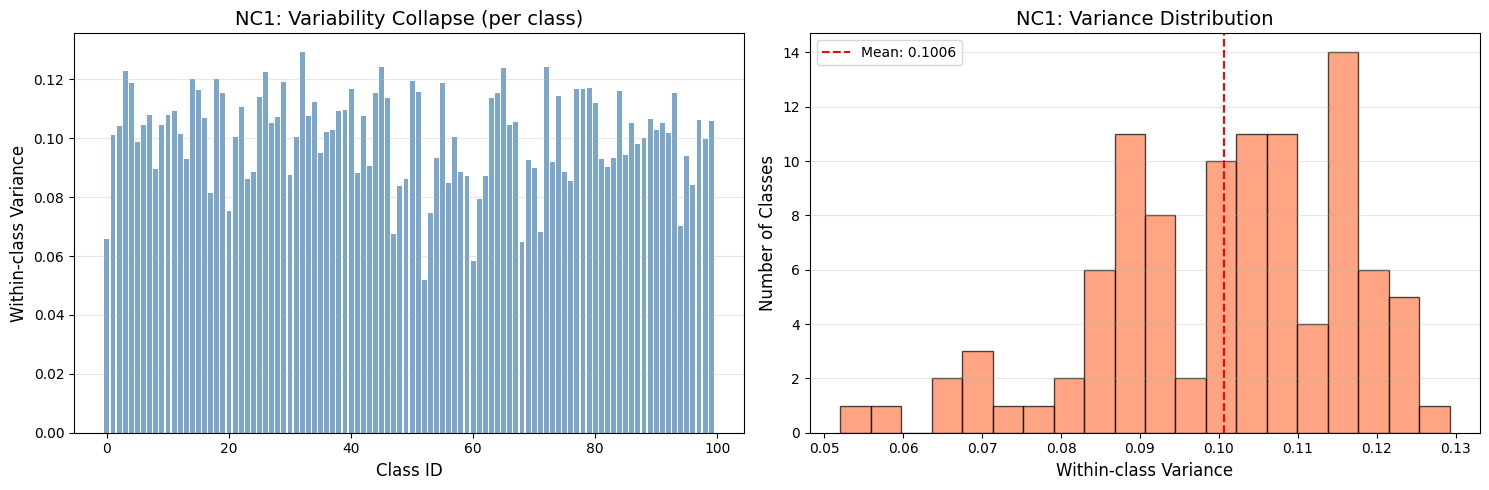


=== Expected NC1 Criteria ===
Mean variance: < 0.01 (the smaller the better, close to zero)
Std variance: < 0.005 (low variance across classes)
Max variance: < 0.05 (even worst class should collapse)
Min variance: < 0.005 (best class nearly perfect)

=== My NC1 Statistics ===
Mean variance: 0.100600
Std variance: 0.015939
Max variance: 0.129216
Min variance: 0.052046

Performing t-SNE dimensionality reduction...


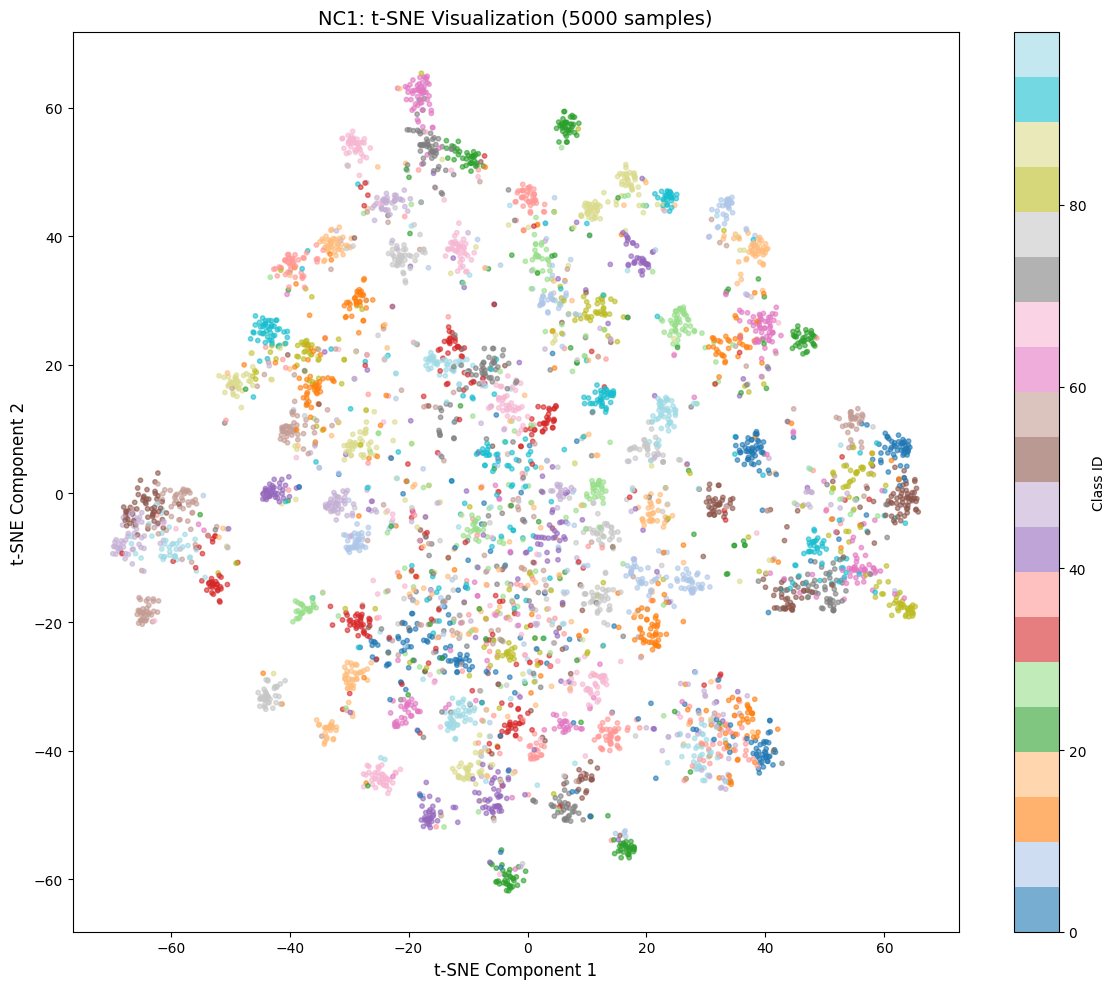

In [63]:
#Visualize NC1 - Variability Collapse

# Plot 1: Per-class variance bar chart
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(range(num_classes), class_variances, color='steelblue', alpha=0.7)
plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Within-class Variance', fontsize=12)
plt.title('NC1: Variability Collapse (per class)', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Plot 2: Variance distribution histogram
plt.subplot(1, 2, 2)
plt.hist(class_variances, bins=20, color='coral', alpha=0.7, edgecolor='black')
plt.xlabel('Within-class Variance', fontsize=12)
plt.ylabel('Number of Classes', fontsize=12)
plt.title('NC1: Variance Distribution', fontsize=14)
plt.axvline(np.mean(class_variances), color='red', linestyle='--', 
            label=f'Mean: {np.mean(class_variances):.4f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('NC1_variance.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print("\n=== Expected NC1 Criteria ===")
print("Mean variance: < 0.01 (the smaller the better, close to zero)")
print("Std variance: < 0.005 (low variance across classes)")
print("Max variance: < 0.05 (even worst class should collapse)")
print("Min variance: < 0.005 (best class nearly perfect)")

print("\n=== My NC1 Statistics ===")
print(f"Mean variance: {np.mean(class_variances):.6f}")
print(f"Std variance: {np.std(class_variances):.6f}")
print(f"Max variance: {np.max(class_variances):.6f}")
print(f"Min variance: {np.min(class_variances):.6f}")

#  t-SNE visualization
print("\nPerforming t-SNE dimensionality reduction...")

sample_size = 5000
sample_indices = np.random.choice(len(train_features), sample_size, replace=False)
features_sample = train_features[sample_indices]
labels_sample = train_labels[sample_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features_sample)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                     c=labels_sample, cmap='tab20', 
                     s=10, alpha=0.6)
plt.colorbar(scatter, label='Class ID')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('NC1: t-SNE Visualization (5000 samples)', fontsize=14)
plt.tight_layout()
plt.savefig('NC1_tsne.png', dpi=150, bbox_inches='tight')
plt.show()


## NC2: convergence to Simplex Equiangular Tight Frame(ETF): the mean centers of different classes form an ETF structure, meaning they are equidistant from each other in the feature space while maximizing angular separation.

### PS: Here I found out the result notcorresponding for NC3-4 and I found out missed centering the data I provide the wrong version here too

In [ ]:
## NC2: Simplex ETF Structure

# Initial Attempt (Non-Centered - INCORRECT)
#Note: This version forgot the centering step, leading to positive correlations
from scipy.spatial.distance import cosine

num_classes = class_means.shape[0]
cosine_similarities = np.zeros((num_classes, num_classes))

for i in range(num_classes):
    for j in range(num_classes):
        if i != j:
            # Cosine similarity = dot product of normalized vectors
            cos_sim = np.dot(class_means[i], class_means[j]) / \
                     (np.linalg.norm(class_means[i]) * np.linalg.norm(class_means[j]))
            cosine_similarities[i, j] = cos_sim
        else:
            cosine_similarities[i, j] = 1.0  # Self-similarity is 1

# Extract upper triangle (unique pairs)
upper_triangle_indices = np.triu_indices(num_classes, k=1)
pairwise_cos_sim = cosine_similarities[upper_triangle_indices]

# Convert cosine similarities to angles (in degrees)
pairwise_angles = np.arccos(np.clip(pairwise_cos_sim, -1, 1)) * 180 / np.pi

# Theoretical ETF value for cosine similarity
theoretical_cos_sim = -1 / (num_classes - 1)
theoretical_angle = np.arccos(theoretical_cos_sim) * 180 / np.pi

print("\n=== My NC2 Statistics ===")
print(f"Computed {len(pairwise_cos_sim)} unique pairwise similarities")
print(f"Theoretical ETF cosine similarity: {theoretical_cos_sim:.6f}")
print(f"Theoretical ETF angle: {theoretical_angle:.2f} degrees")



=== My NC2 Statistics ===
Computed 4950 unique pairwise similarities
Theoretical ETF cosine similarity: -0.010101
Theoretical ETF angle: 90.58 degrees


In [ ]:
# NC2 CORRECTED (with centering)

print("\n=== NC2 CORRECTED VERSION (with centering) ===")

# CRITICAL FIX: Center class means relative to global mean
global_mean = np.mean(class_means, axis=0)
centered_class_means = class_means - global_mean

print(f"Global mean norm: {np.linalg.norm(global_mean):.4f}")
print(f"Centered verification (should be ~0): {np.linalg.norm(np.mean(centered_class_means, axis=0)):.6f}")

# Compute pairwise cosine similarities on CENTERED data
num_classes = centered_class_means.shape[0]
cosine_similarities = np.zeros((num_classes, num_classes))

print("Computing CENTERED pairwise cosine similarities...")
for i in range(num_classes):
    for j in range(num_classes):
        if i != j:
            cos_sim = np.dot(centered_class_means[i], centered_class_means[j]) / \
                     (np.linalg.norm(centered_class_means[i]) * np.linalg.norm(centered_class_means[j]))
            cosine_similarities[i, j] = cos_sim
        else:
            cosine_similarities[i, j] = 1.0

# Extract unique pairs
upper_triangle_indices = np.triu_indices(num_classes, k=1)
pairwise_cos_sim = cosine_similarities[upper_triangle_indices]
pairwise_angles = np.arccos(np.clip(pairwise_cos_sim, -1, 1)) * 180 / np.pi

# Theoretical ETF
theoretical_cos_sim = -1 / (num_classes - 1)
theoretical_angle = np.arccos(theoretical_cos_sim) * 180 / np.pi

print(f"Computed {len(pairwise_cos_sim)} unique pairwise similarities")
print(f"Theoretical ETF cosine similarity: {theoretical_cos_sim:.6f}")
print(f"Theoretical ETF angle: {theoretical_angle:.2f} degrees")


=== NC2 CORRECTED VERSION (with centering) ===
Global mean norm: 7.6013
Centered verification (should be ~0): 0.000000
Computing CENTERED pairwise cosine similarities...
Computed 4950 unique pairwise similarities
Theoretical ETF cosine similarity: -0.010101
Theoretical ETF angle: 90.58 degrees


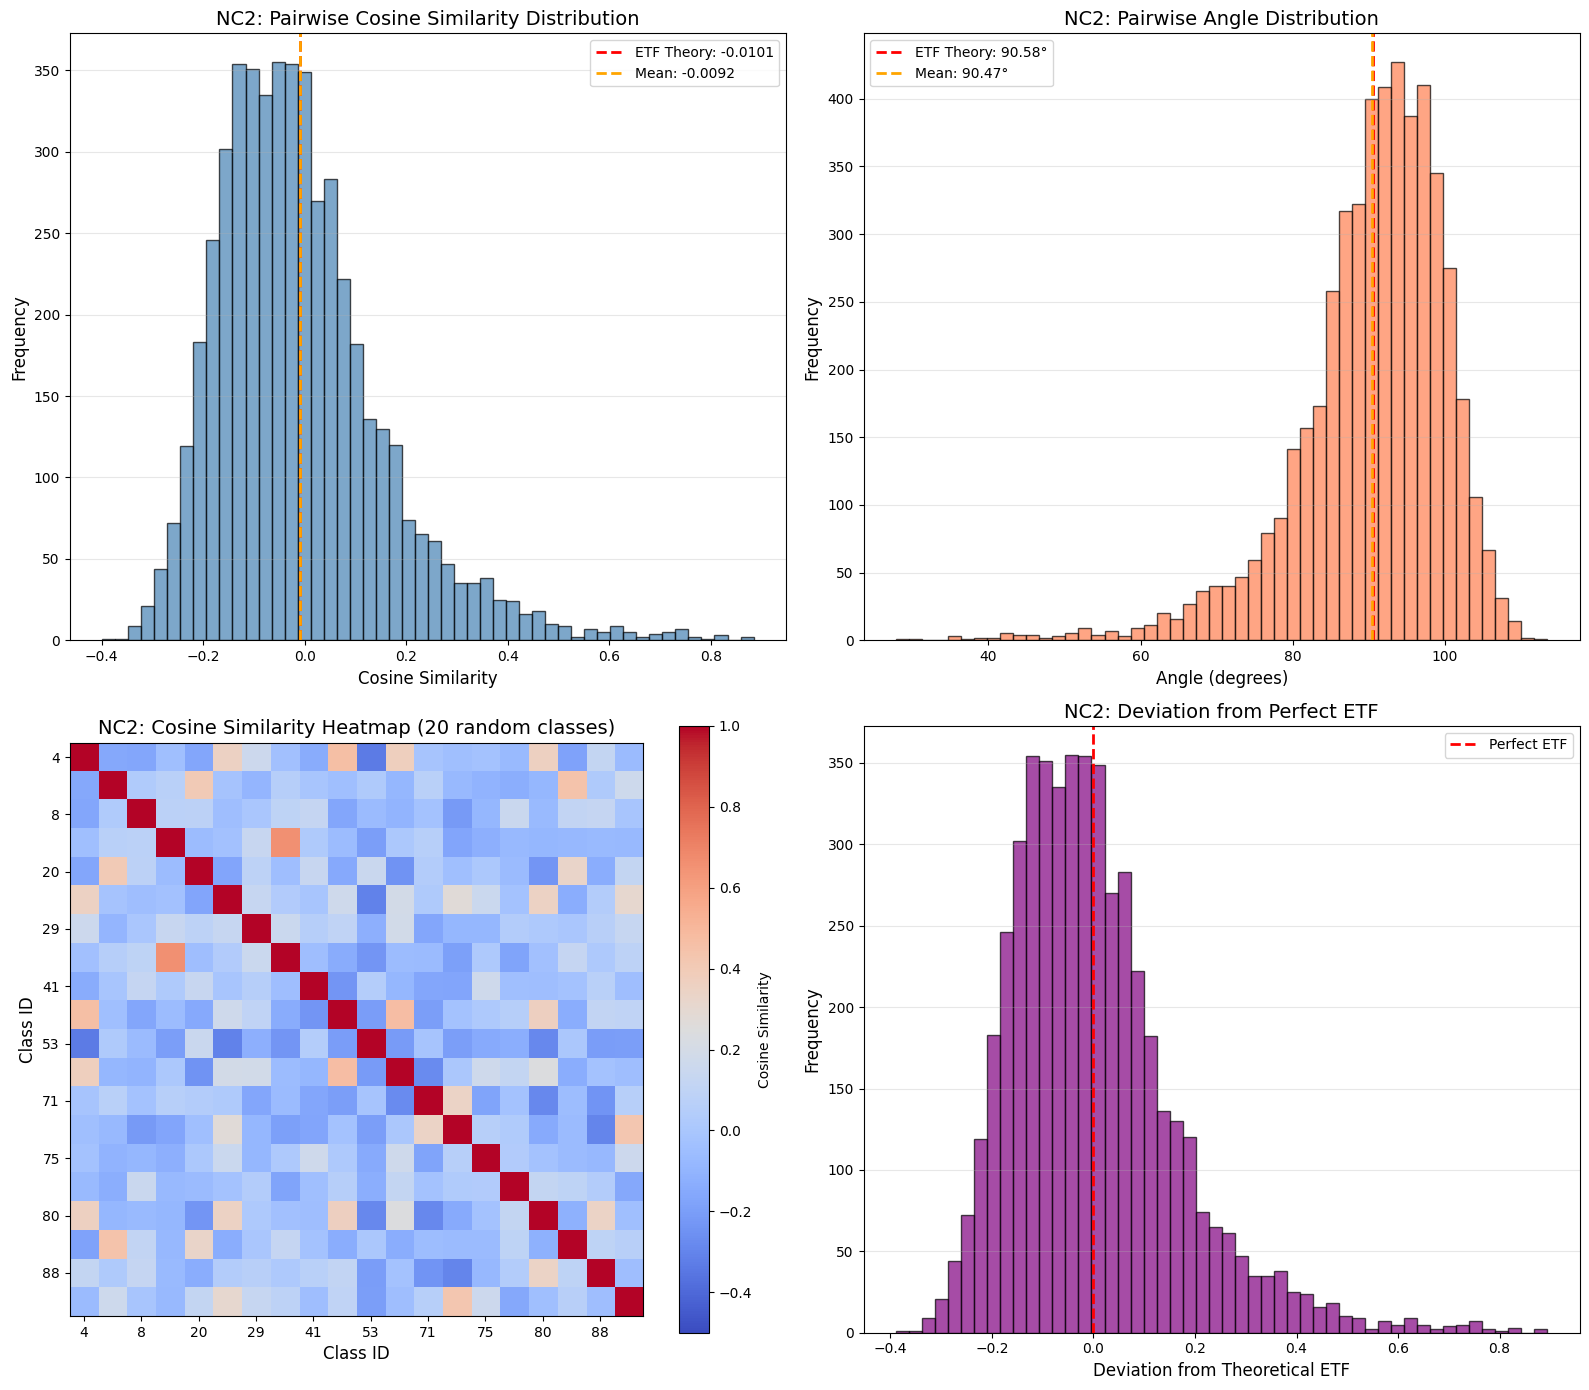


=== Expected NC2 Criteria ===
Theoretical cosine similarity: -0.010101
Theoretical angle: 90.58 degrees
Deviation std should be < 0.05 for strong NC2

=== My NC2 Statistics ===
Mean cosine similarity: -0.009213
Std cosine similarity: 0.166318
Mean angle: 90.47 degrees
Std angle: 9.84 degrees
Mean deviation from ETF: 0.000888
Std deviation from ETF: 0.166318

=== NC2 Assessment ===
No NC2: Class means do not form ETF structure

Status: Std deviation (0.1663) from theoretical ETF


In [74]:
# NC2 Visualization ( right and wrong version can share this to plot)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Cosine similarity distribution
axes[0, 0].hist(pairwise_cos_sim, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(theoretical_cos_sim, color='red', linestyle='--', linewidth=2,
                   label=f'ETF Theory: {theoretical_cos_sim:.4f}')
axes[0, 0].axvline(np.mean(pairwise_cos_sim), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(pairwise_cos_sim):.4f}')
axes[0, 0].set_xlabel('Cosine Similarity', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('NC2: Pairwise Cosine Similarity Distribution', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Angle distribution
axes[0, 1].hist(pairwise_angles, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(theoretical_angle, color='red', linestyle='--', linewidth=2,
                   label=f'ETF Theory: {theoretical_angle:.2f}°')
axes[0, 1].axvline(np.mean(pairwise_angles), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(pairwise_angles):.2f}°')
axes[0, 1].set_xlabel('Angle (degrees)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('NC2: Pairwise Angle Distribution', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Cosine similarity heatmap (for 20 random classes)
sample_classes = np.random.choice(num_classes, 20, replace=False)
sample_classes = np.sort(sample_classes)
cos_sim_sample = cosine_similarities[np.ix_(sample_classes, sample_classes)]

im = axes[1, 0].imshow(cos_sim_sample, cmap='coolwarm', vmin=-0.5, vmax=1.0)
axes[1, 0].set_xlabel('Class ID', fontsize=12)
axes[1, 0].set_ylabel('Class ID', fontsize=12)
axes[1, 0].set_title('NC2: Cosine Similarity Heatmap (20 random classes)', fontsize=14)
axes[1, 0].set_xticks(range(0, 20, 2))
axes[1, 0].set_xticklabels(sample_classes[::2])
axes[1, 0].set_yticks(range(0, 20, 2))
axes[1, 0].set_yticklabels(sample_classes[::2])
plt.colorbar(im, ax=axes[1, 0], label='Cosine Similarity')

# Plot 4: Deviation from ETF
deviation_from_etf = pairwise_cos_sim - theoretical_cos_sim
axes[1, 1].hist(deviation_from_etf, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect ETF')
axes[1, 1].set_xlabel('Deviation from Theoretical ETF', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('NC2: Deviation from Perfect ETF', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('NC2_etf_structure.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
print("\n=== Expected NC2 Criteria ===")
print(f"Theoretical cosine similarity: {theoretical_cos_sim:.6f}")
print(f"Theoretical angle: {theoretical_angle:.2f} degrees")
print("Deviation std should be < 0.05 for strong NC2")

print("\n=== My NC2 Statistics ===")
print(f"Mean cosine similarity: {np.mean(pairwise_cos_sim):.6f}")
print(f"Std cosine similarity: {np.std(pairwise_cos_sim):.6f}")
print(f"Mean angle: {np.mean(pairwise_angles):.2f} degrees")
print(f"Std angle: {np.std(pairwise_angles):.2f} degrees")
print(f"Mean deviation from ETF: {np.mean(deviation_from_etf):.6f}")
print(f"Std deviation from ETF: {np.std(deviation_from_etf):.6f}")

print("\n=== NC2 Assessment ===")
std_dev = np.std(deviation_from_etf)
if std_dev < 0.02:
    print("Strong NC2: Class means form near-perfect ETF structure")
elif std_dev < 0.05:
    print("Partial NC2: Moderate ETF structure with some variance")
elif std_dev < 0.10:
    print("Weak NC2: Some ETF structure but significant deviation")
else:
    print("No NC2: Class means do not form ETF structure")

print(f"\nStatus: Std deviation ({std_dev:.4f}) from theoretical ETF")


## NC3: convergence to self-duaality: the class means and linear classifiers converges to each other, up to rescaling.

In [67]:
final_layer = model.fc[-1]  # Get the Linear layer
classifier_weights = final_layer.weight.data.cpu().numpy()  # [100, 512]

print(f"Classifier weights shape: {classifier_weights.shape}")
print(f"Class means shape: {class_means.shape}")

# Compute correlations and angles for each class
num_classes = class_means.shape[0]
correlations = []
angles = []

for i in range(num_classes):
    mean_i = class_means[i]
    weight_i = classifier_weights[i]
    
    # Pearson correlation
    corr, _ = pearsonr(mean_i, weight_i)
    correlations.append(corr)
    
    # Angle between vectors
    cos_angle = np.dot(mean_i, weight_i) / (np.linalg.norm(mean_i) * np.linalg.norm(weight_i))
    angle = np.arccos(np.clip(cos_angle, -1, 1)) * 180 / np.pi
    angles.append(angle)

correlations = np.array(correlations)
angles = np.array(angles)

print(f"Computed {len(correlations)} class alignments")


Classifier weights shape: (100, 512)
Class means shape: (100, 512)
Computed 100 class alignments


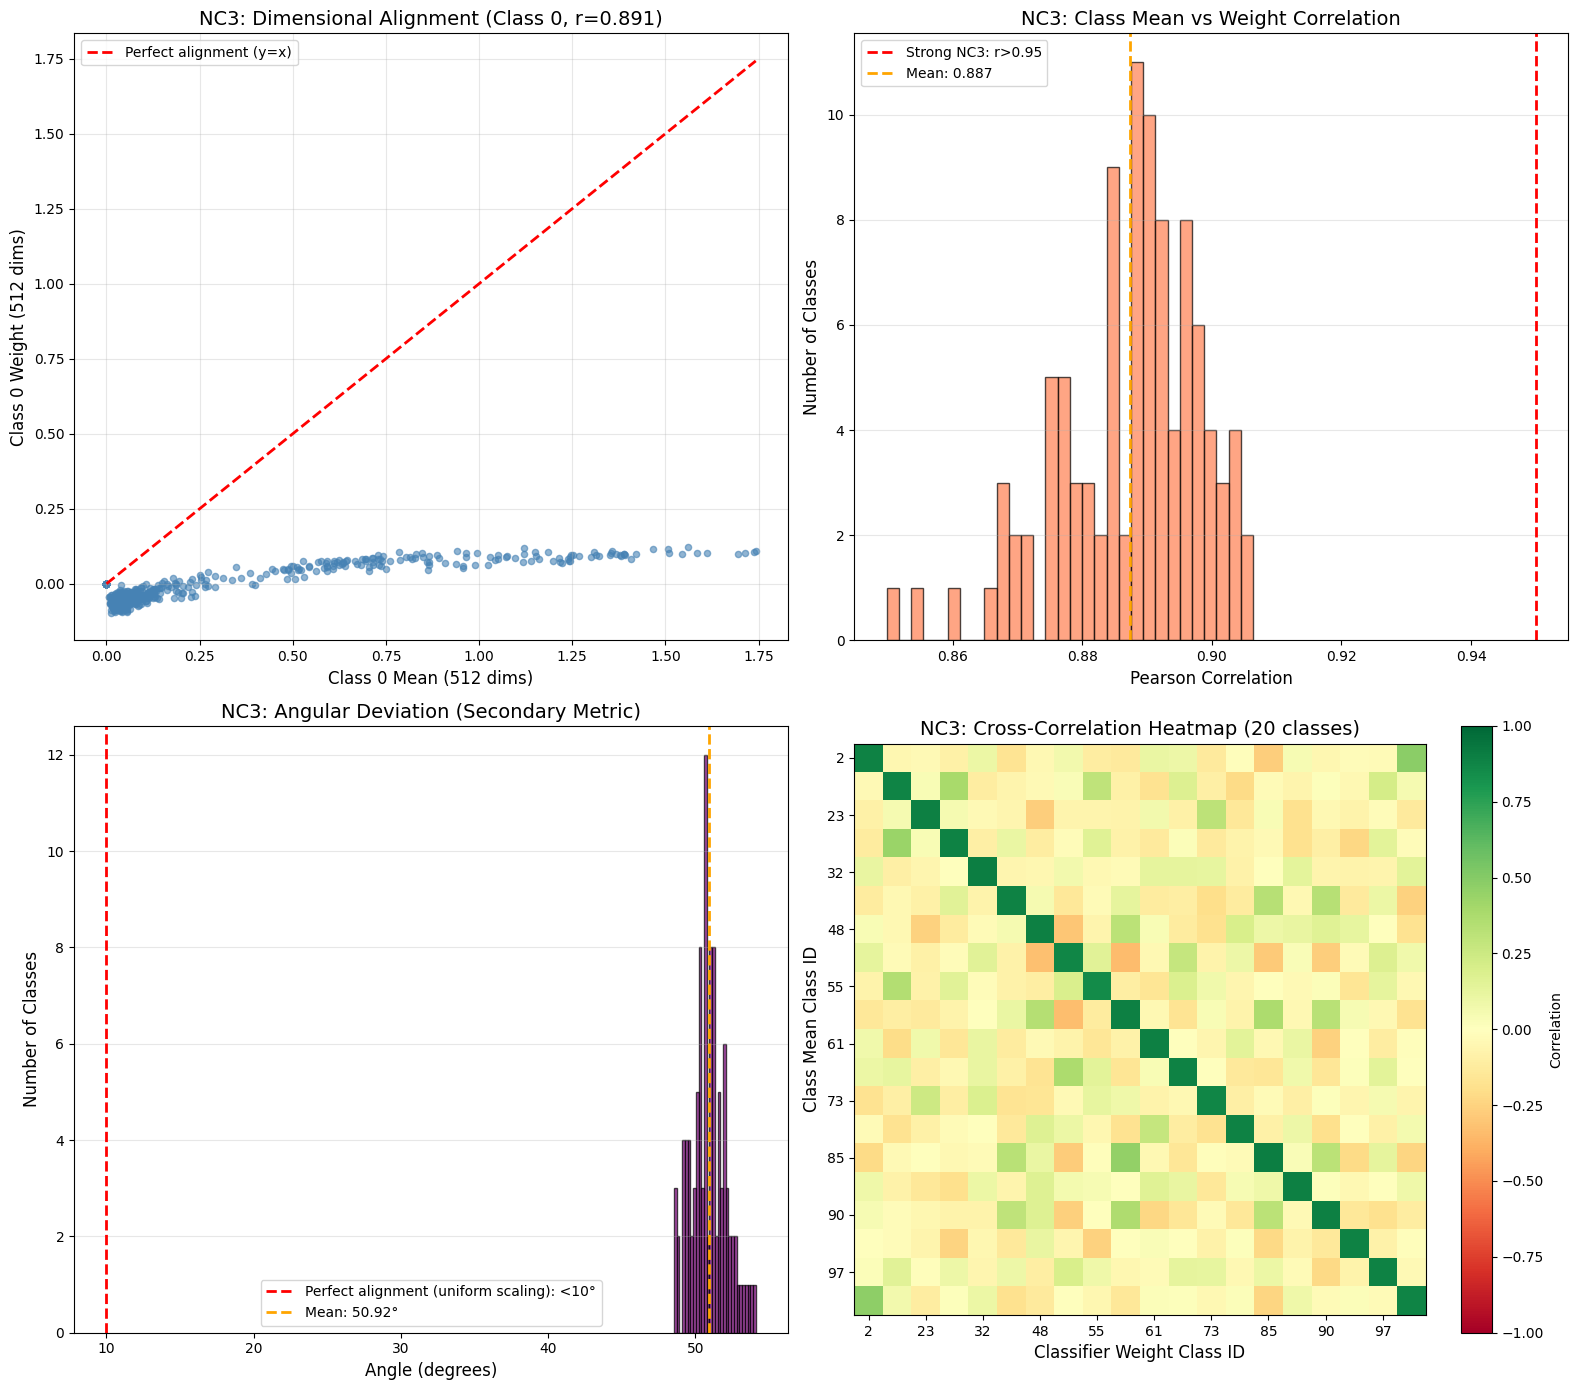


=== Expected NC3 Criteria ===
Mean correlation: > 0.95 for strong NC3
Mean angle: < 10 degrees for strong NC3
All classes should show high positive correlation

=== My NC3 Statistics ===
Mean correlation: 0.887390
Std correlation: 0.011139
Min correlation: 0.849838
Max correlation: 0.906367
Mean angle: 50.92 degrees
Std angle: 1.22 degrees

=== NC3 Assessment ===
Partial NC3: Moderate alignment between means and weights

Status: Mean correlation (0.887) indicates alignment strength
Classes with high alignment (>0.8): 100/100
Classes with poor alignment (<0.5): 0/100


In [75]:
# NC3 Visualization

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Scatter plot for one representative class
sample_class = 0
axes[0, 0].scatter(class_means[sample_class], classifier_weights[sample_class], 
                   s=20, alpha=0.6, color='steelblue')
axes[0, 0].plot([class_means[sample_class].min(), class_means[sample_class].max()],
                [class_means[sample_class].min(), class_means[sample_class].max()],
                'r--', linewidth=2, label='Perfect alignment (y=x)')
axes[0, 0].set_xlabel(f'Class {sample_class} Mean (512 dims)', fontsize=12)
axes[0, 0].set_ylabel(f'Class {sample_class} Weight (512 dims)', fontsize=12)
axes[0, 0].set_title(f'NC3: Dimensional Alignment (Class {sample_class}, r={correlations[sample_class]:.3f})', 
                     fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Correlation distribution across all classes
axes[0, 1].hist(correlations, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0.95, color='red', linestyle='--', linewidth=2, label='Strong NC3: r>0.95')
axes[0, 1].axvline(np.mean(correlations), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(correlations):.3f}')
axes[0, 1].set_xlabel('Pearson Correlation', fontsize=12)
axes[0, 1].set_ylabel('Number of Classes', fontsize=12)
axes[0, 1].set_title('NC3: Class Mean vs Weight Correlation', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Angle distribution
axes[1, 0].hist(angles, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(10, color='red', linestyle='--', linewidth=2, 
                   label='Perfect alignment (uniform scaling): <10°')  # 改为"Perfect"而非"Strong NC3"
axes[1, 0].axvline(np.mean(angles), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(angles):.2f}°')
axes[1, 0].set_xlabel('Angle (degrees)', fontsize=12)
axes[1, 0].set_ylabel('Number of Classes', fontsize=12)
axes[1, 0].set_title('NC3: Angular Deviation (Secondary Metric)', fontsize=14)  # 标注为"次要指标"
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Heatmap of top correlations (20 classes sample)
sample_classes = np.random.choice(num_classes, 20, replace=False)
sample_classes = np.sort(sample_classes)
correlation_matrix = np.zeros((20, 20))

for idx_i, i in enumerate(sample_classes):
    for idx_j, j in enumerate(sample_classes):
        corr, _ = pearsonr(class_means[i], classifier_weights[j])
        correlation_matrix[idx_i, idx_j] = corr

im = axes[1, 1].imshow(correlation_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1, 1].set_xlabel('Classifier Weight Class ID', fontsize=12)
axes[1, 1].set_ylabel('Class Mean Class ID', fontsize=12)
axes[1, 1].set_title('NC3: Cross-Correlation Heatmap (20 classes)', fontsize=14)
axes[1, 1].set_xticks(range(0, 20, 2))
axes[1, 1].set_xticklabels(sample_classes[::2])
axes[1, 1].set_yticks(range(0, 20, 2))
axes[1, 1].set_yticklabels(sample_classes[::2])
plt.colorbar(im, ax=axes[1, 1], label='Correlation')

plt.tight_layout()
plt.savefig('NC3_self_duality.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
print("\n=== Expected NC3 Criteria ===")
print("Mean correlation: > 0.95 for strong NC3")
print("Mean angle: < 10 degrees for strong NC3")
print("All classes should show high positive correlation")

print("\n=== My NC3 Statistics ===")
print(f"Mean correlation: {np.mean(correlations):.6f}")
print(f"Std correlation: {np.std(correlations):.6f}")
print(f"Min correlation: {np.min(correlations):.6f}")
print(f"Max correlation: {np.max(correlations):.6f}")
print(f"Mean angle: {np.mean(angles):.2f} degrees")
print(f"Std angle: {np.std(angles):.2f} degrees")

print("\n=== NC3 Assessment ===")
mean_corr = np.mean(correlations)
if mean_corr > 0.95:
    print("Strong NC3: Class means and weights are highly aligned")
elif mean_corr > 0.7:
    print("Partial NC3: Moderate alignment between means and weights")
elif mean_corr > 0.5:
    print("Weak NC3: Some alignment but significant deviation")
else:
    print("No NC3: Class means and weights are not aligned")

print(f"\nStatus: Mean correlation ({mean_corr:.3f}) indicates alignment strength")
print(f"Classes with high alignment (>0.8): {np.sum(correlations > 0.8)}/100")
print(f"Classes with poor alignment (<0.5): {np.sum(correlations < 0.5)}/100")


## NC4: simplification to nearest-class center: the behavior of the classifier ultimately simplifies to classification based on the nearest class centers in the feature space.

In [69]:
# Extract test set features and predictions
def extract_test_predictions(model, test_loader, class_means, device='cuda'):
    model.eval()
    
    all_features = []
    all_labels = []
    all_model_preds = []
    all_nearest_preds = []
    
    # Hook for feature extraction
    features_buffer = []
    def hook_fn(module, input, output):
        features_buffer.append(output.view(output.size(0), -1).detach().cpu())
    
    hook_handle = model.avgpool.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            
            # Get model predictions
            logits = model(images)
            model_preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            # Get features
            features = features_buffer[-1].numpy()
            
            # Compute nearest center predictions
            nearest_preds = []
            for feat in features:
                distances = np.linalg.norm(class_means - feat, axis=1)
                nearest_preds.append(np.argmin(distances))
            
            all_features.append(features)
            all_labels.append(labels.numpy())
            all_model_preds.append(model_preds)
            all_nearest_preds.append(np.array(nearest_preds))
            
            features_buffer.clear()
    
    hook_handle.remove()
    
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_model_preds = np.concatenate(all_model_preds, axis=0)
    all_nearest_preds = np.concatenate(all_nearest_preds, axis=0)
    
    return all_features, all_labels, all_model_preds, all_nearest_preds

print("Extracting test set predictions...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_features, test_labels, model_preds, nearest_preds = extract_test_predictions(
    model, test_loader, class_means, device=device
)

print(f"Test samples: {len(test_labels)}")
print(f"Model predictions: {model_preds.shape}")
print(f"Nearest center predictions: {nearest_preds.shape}")

# Compute consistency per class
num_classes = 100
consistency_per_class = []
samples_per_class = []

for class_id in range(num_classes):
    class_mask = (test_labels == class_id)
    class_model_preds = model_preds[class_mask]
    class_nearest_preds = nearest_preds[class_mask]
    
    if len(class_model_preds) > 0:
        consistency = np.mean(class_model_preds == class_nearest_preds) * 100
        consistency_per_class.append(consistency)
        samples_per_class.append(len(class_model_preds))
    else:
        consistency_per_class.append(0)
        samples_per_class.append(0)

consistency_per_class = np.array(consistency_per_class)
overall_consistency = np.mean(model_preds == nearest_preds) * 100

print(f"Overall consistency: {overall_consistency:.2f}%")


Extracting test set predictions...
Test samples: 10000
Model predictions: (10000,)
Nearest center predictions: (10000,)
Overall consistency: 91.43%


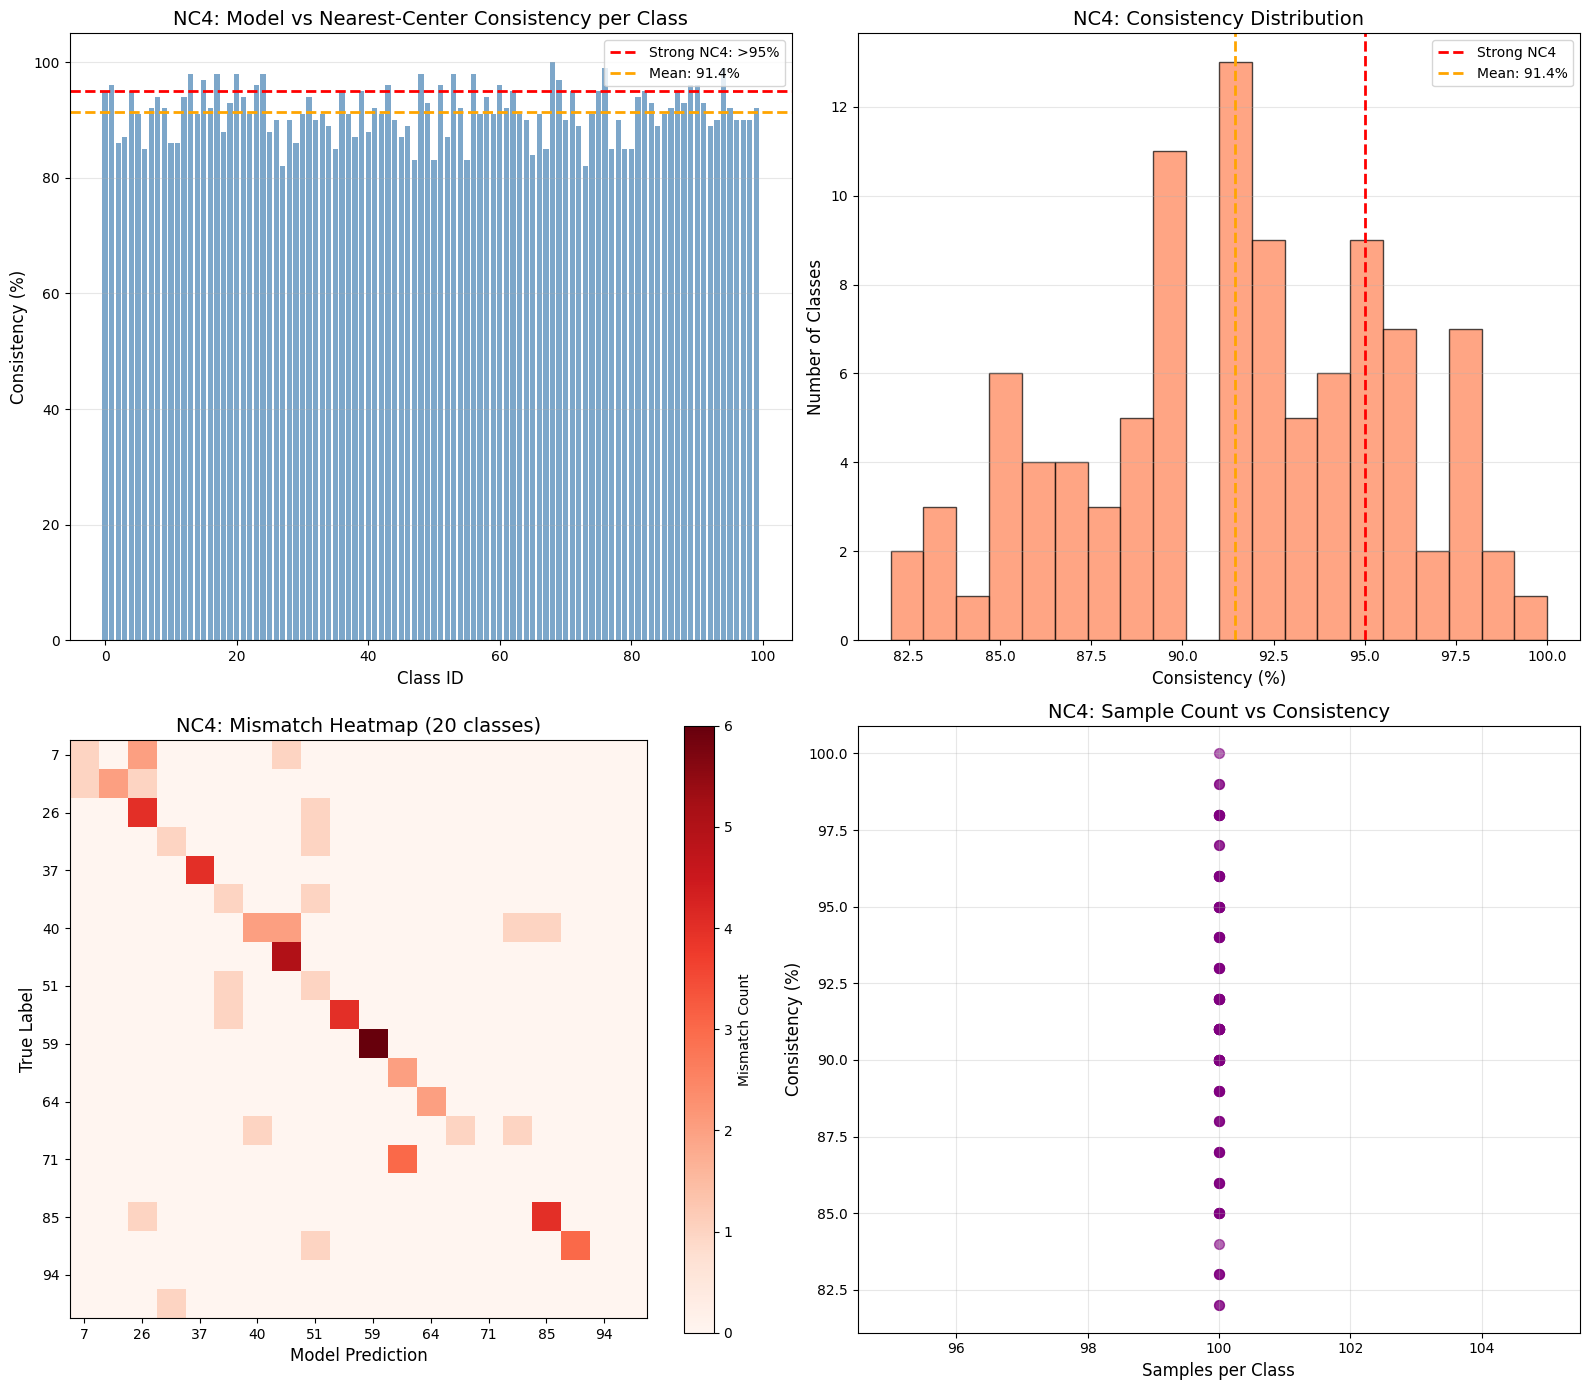


=== Expected NC4 Criteria ===
Overall consistency: > 95% for strong NC4
Most classes: > 90% consistency
Model decisions match nearest-center decisions

=== My NC4 Statistics ===
Overall consistency: 91.43%
Mean per-class consistency: 91.43%
Std per-class consistency: 4.30%
Min consistency: 82.00%
Max consistency: 100.00%
Classes with >90% consistency: 61/100
Classes with >80% consistency: 100/100
Classes with <70% consistency: 0/100

=== NC4 Assessment ===
[Partial NC4] Moderate alignment with nearest-center principle

Status: 91.4% of predictions match nearest class center
This indicates strong NC4 behavior


In [70]:
# NC4 Visualization

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Consistency per class
axes[0, 0].bar(range(num_classes), consistency_per_class, color='steelblue', alpha=0.7)
axes[0, 0].axhline(95, color='red', linestyle='--', linewidth=2, label='Strong NC4: >95%')
axes[0, 0].axhline(overall_consistency, color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {overall_consistency:.1f}%')
axes[0, 0].set_xlabel('Class ID', fontsize=12)
axes[0, 0].set_ylabel('Consistency (%)', fontsize=12)
axes[0, 0].set_title('NC4: Model vs Nearest-Center Consistency per Class', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Consistency distribution
axes[0, 1].hist(consistency_per_class, bins=20, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(95, color='red', linestyle='--', linewidth=2, label='Strong NC4')
axes[0, 1].axvline(overall_consistency, color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {overall_consistency:.1f}%')
axes[0, 1].set_xlabel('Consistency (%)', fontsize=12)
axes[0, 1].set_ylabel('Number of Classes', fontsize=12)
axes[0, 1].set_title('NC4: Consistency Distribution', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Confusion-style heatmap (sample 20 classes)
sample_classes = np.random.choice(num_classes, 20, replace=False)
sample_classes = np.sort(sample_classes)

confusion_sample = np.zeros((20, 20))
for idx_i, true_class in enumerate(sample_classes):
    class_mask = (test_labels == true_class)
    for idx_j, pred_class in enumerate(sample_classes):
        # Count mismatches where model predicts pred_class but nearest is different
        mismatch_mask = (model_preds[class_mask] == pred_class) & \
                       (nearest_preds[class_mask] != pred_class)
        confusion_sample[idx_i, idx_j] = np.sum(mismatch_mask)

im = axes[1, 0].imshow(confusion_sample, cmap='Reds', vmin=0, vmax=confusion_sample.max())
axes[1, 0].set_xlabel('Model Prediction', fontsize=12)
axes[1, 0].set_ylabel('True Label', fontsize=12)
axes[1, 0].set_title('NC4: Mismatch Heatmap (20 classes)', fontsize=14)
axes[1, 0].set_xticks(range(0, 20, 2))
axes[1, 0].set_xticklabels(sample_classes[::2])
axes[1, 0].set_yticks(range(0, 20, 2))
axes[1, 0].set_yticklabels(sample_classes[::2])
plt.colorbar(im, ax=axes[1, 0], label='Mismatch Count')

# Plot 4: Sample count vs consistency
axes[1, 1].scatter(samples_per_class, consistency_per_class, s=50, alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Samples per Class', fontsize=12)
axes[1, 1].set_ylabel('Consistency (%)', fontsize=12)
axes[1, 1].set_title('NC4: Sample Count vs Consistency', fontsize=14)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('NC4_nearest_center.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics (no emoji or special symbols)
print("\n=== Expected NC4 Criteria ===")
print("Overall consistency: > 95% for strong NC4")
print("Most classes: > 90% consistency")
print("Model decisions match nearest-center decisions")

print("\n=== My NC4 Statistics ===")
print(f"Overall consistency: {overall_consistency:.2f}%")
print(f"Mean per-class consistency: {np.mean(consistency_per_class):.2f}%")
print(f"Std per-class consistency: {np.std(consistency_per_class):.2f}%")
print(f"Min consistency: {np.min(consistency_per_class):.2f}%")
print(f"Max consistency: {np.max(consistency_per_class):.2f}%")
print(f"Classes with >90% consistency: {np.sum(consistency_per_class > 90)}/100")
print(f"Classes with >80% consistency: {np.sum(consistency_per_class > 80)}/100")
print(f"Classes with <70% consistency: {np.sum(consistency_per_class < 70)}/100")

print("\n=== NC4 Assessment ===")
if overall_consistency > 95:
    print("[Strong NC4] Model predictions strongly align with nearest-center decisions")
elif overall_consistency > 85:
    print("[Partial NC4] Moderate alignment with nearest-center principle")
elif overall_consistency > 75:
    print("[Weak NC4] Some alignment but significant deviations")
else:
    print("[No NC4] Model does not follow nearest-center classification")

print(f"\nStatus: {overall_consistency:.1f}% of predictions match nearest class center")
print(f"This indicates {'strong' if overall_consistency > 90 else 'moderate' if overall_consistency > 80 else 'weak'} NC4 behavior")


# 4. Study the Neural Collapse phenomenon at the end of training NC5. 

## NC5: ID/OOD orthogonality: as training progresses, the clusters of OOD data become increasingly orthogonal to the configuration adopted by ID data.

# 5. Implementation of the NECO method (Neural Collapse Inspired OOD Detection).

$$ NECO(x)=\frac{||P~h_{\omega}(x)||}{||h_{\omega}(x)||} \\
=\frac{\sqrt{h_{\omega}(x)^\top PP^\top h_{\omega}(x)}}{\sqrt{h_{\omega}(x)^\top h_{\omega}(x)}}$$

With $h_{\omega}(x)$ the penultimate layer representation and $P$ the projection matrix on the biggest $d$-eigenvectors.

$P$ is fitted using a PCA on the in-distribution training features.

NECO is rescaled by the maximum-logit value. This has the effect of injecting class-based information.

In [71]:
import torch
import numpy as np
from sklearn.decomposition import PCA

class NECODetector:
    def __init__(self, model, num_classes):
        """
        NECO OOD Detector initialization.
        :param model: pre-trained neural network model
        :param num_classes: ID dataset class count (used to determine PCA components)
        """
        self.model = model
        self.model.eval()
        self.pca_components = None
        self.d = num_classes
        
        # Internal buffer for feature extraction
        self.features_buffer = []
        # Register hook to extract features from avgpool layer
        self.hook_handle = self.model.avgpool.register_forward_hook(self._hook_fn)

    def _hook_fn(self, module, input, output):
        # ResNet avgpool output is [batch, 512, 1, 1], flatten to [batch, 512]
        self.features_buffer.append(output.view(output.size(0), -1))

    def get_features_and_logits(self, inputs):
        """
        Extract features (penultimate layer) and logits.
        """
        self.features_buffer.clear()
        logits = self.model(inputs)
        features = self.features_buffer[0]
        return features, logits

    def fit(self, train_loader):
        """
        OOD fitting phase: Compute projection matrix P using PCA on ID training features.
        :param train_loader: ID training data loader
        """
        print("Extracting ID features for PCA fitting...")
        all_features = []
        self.model.eval()
        
        with torch.no_grad():
            for inputs, _ in train_loader:
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                features, _ = self.get_features_and_logits(inputs)
                all_features.append(features.cpu().numpy())
            
        all_features = np.concatenate(all_features, axis=0)
        
        # PCA to find the top-d components
        print(f"Fitting PCA with top-{self.d} components...")
        pca = PCA(n_components=self.d)
        pca.fit(all_features)
        
        # Save components (Eigenvectors) as the projection basis
        # components_ shape: [n_components, feature_dim]
        self.pca_components = torch.from_numpy(pca.components_).float()
        
        if torch.cuda.is_available():
            self.pca_components = self.pca_components.cuda()
            
        print("NECO fitting complete.")

    def predict_score(self, inputs):
        """
        Online inference phase: Compute NECO score for a batch of inputs.
        :param inputs: Test input batch
        :return: OOD scores (higher means more likely ID)
        """
        if self.pca_components is None:
            raise ValueError("Run .fit() before prediction!")

        if torch.cuda.is_available():
            inputs = inputs.cuda()
        
        with torch.no_grad():
            h, logits = self.get_features_and_logits(inputs)
            
            # Project features onto the PCA subspace            
            h_reduced = torch.matmul(h, self.pca_components.T) # h_reduced = h @ V.T (projects to d-dim space)
            norm_Ph = torch.norm(h_reduced, p=2, dim=1) # ||Ph|| = ||h_reduced|| since P is the projection onto the PCA subspace
            norm_h = torch.norm(h, p=2, dim=1) # ||h(x)||
            ratio = norm_Ph / (norm_h + 1e-8)

            # Final NECO score
            max_logits, _ = torch.max(logits, dim=1)
            neco_scores = ratio * max_logits
        
        return neco_scores
    
    def clean_up(self):
        if self.hook_handle:
            self.hook_handle.remove()

In [72]:
# Compute NECO scores
neco_detector = NECODetector(model, num_classes=100)
neco_detector.fit(train_loader)

print("Computing NECO scores for test set...")
all_neco_scores = []
# Iterate over test loader like other methods
for inputs, _ in test_loader:
    scores = neco_detector.predict_score(inputs)
    all_neco_scores.append(scores.cpu())

neco_scores = torch.cat(all_neco_scores)
print(f"NECO scores (first 10): {neco_scores[:10]}")

# Cleanup hook
neco_detector.clean_up()

Extracting ID features for PCA fitting...
Fitting PCA with top-100 components...
NECO fitting complete.
Computing NECO scores for test set...
NECO scores (first 10): tensor([ 5.6232,  8.4700,  6.3764,  3.8522, 12.7030,  7.3703,  5.8127,  5.7500,
         9.8897, 11.6809])


# 7. Consensus Analysis: Identifying Suspicious Samples
We can compare the "most suspicious" samples (highest OOD probability) identified by each method. Overlap suggests a robust detection of an outlier or hard sample.
We select the Top-K samples that appear most "OOD-like" according to each metric and check for consensus.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def get_suspicious_indices(scores, k=20, method_name="", high_score_is_ood=False):
    """
    Returns indices of the top k most suspicious samples.
    If high_score_is_ood is True, takes top k highest scores.
    If high_score_is_ood is False, takes top k lowest scores.
    """
    if high_score_is_ood:
        indices = torch.argsort(scores, descending=True)[:k]
    else:
        indices = torch.argsort(scores, descending=False)[:k]
    return indices.cpu().numpy()

# Number of samples to inspect
K = 20

# Gather suspicious indices from each method
# MSP: Low score -> OOD
idx_msp = get_suspicious_indices(msp_scores, K, "MSP", False)

# MaxLogit: Low score -> OOD
idx_logit = get_suspicious_indices(max_logit_scores, K, "MaxLogit", False)

# Energy: Low score -> OOD
idx_energy = get_suspicious_indices(energy_scores, K, "Energy", False)

# Mahalanobis: Low score -> OOD
idx_maha = get_suspicious_indices(mahalanobis_scores, K, "Mahalanobis", False)

# ViM: High score -> OOD
idx_vim = get_suspicious_indices(vim_scores, K, "ViM", True)

# NECO: Low score -> OOD
idx_neco = get_suspicious_indices(neco_scores, K, "NECO", False)

# Compare Overlaps
method_indices = {
    "MSP": idx_msp,
    "MaxLogit": idx_logit,
    "Energy": idx_energy,
    "Mahalanobis": idx_maha,
    "ViM": idx_vim,
    "NECO": idx_neco
}

print(f"Top {K} suspicious OOD candidates per method:")
for name, idxs in method_indices.items():
    print(f"{name}: {idxs}")

# Find Intersection
all_sets = [set(v) for v in method_indices.values()]
intersection = set.intersection(*all_sets)
print(f"\nIntersection (detected by ALL methods): {intersection if intersection else 'None'}")

# Find Consensus (detected by at least N methods)
all_indices_flat = np.concatenate(list(method_indices.values()))
counts = Counter(all_indices_flat)

print("\nMost suspicious samples (Majority Vote >= 4 methods):")
sorted_consensus = sorted(counts.items(), key=lambda x: x[1], reverse=True)
consensus_indices = []
for idx, count in sorted_consensus:
    if count >= 4:
        print(f"Sample {idx}: detected by {count} methods")
        consensus_indices.append(idx)



Top 20 suspicious OOD candidates per method:
MSP: [7370 2401 6671 1061 4284 1721 3945 6148 5859 4413 5831 3761 2803 9348
 4798 4510 9021 4565  167 2420]
MaxLogit: [1061 7370 1721 2401 6671 3761 3945 4284 4510 4798 5859 5570 2420 6148
  879 1345 6020 3169 6997 6127]
Energy: [5570 4510 3761 1721 9798 1061 3036 6885  901 7877 9817 1449 8995 3858
 5972 3757 4798 1280 3666 4525]
Mahalanobis: [6117 7295 5772 2756 8735 2903 1638 2202 8981 3602  681 7569 9362  119
 7145 3986 5501 6297 7194  499]
ViM: [1721 4157 1345 5570 4895 7276 9494 4510 1123 1687 2401 4021 6187  901
 5819 3036 1527 2071 6682 4525]
NECO: [1061 7370 1721 2401 6671 4284 3761 4510 3945 4798 5859 5570 2420 6148
  879 6997 6020 3169 1345 6254]

Intersection (detected by ALL methods): None

Most suspicious samples (Majority Vote >= 4 methods):
Sample 1721: detected by 5 methods
Sample 4510: detected by 5 methods
Sample 2401: detected by 4 methods
Sample 1061: detected by 4 methods
Sample 3761: detected by 4 methods
Sample 4798: d